In [1]:
# Khai báo thư viện
!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score
import xgboost as xgb

In [2]:
data_fpt = "D:\\Downloads\\FPT.csv"
fpt_df = pd.read_csv(data_fpt)
fpt_df

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,12/25/2022 9:15,30.89,30.89,30.89,30.89,35410,0
1,FPT,12/25/2022 9:16,30.81,30.81,30.81,30.81,190,0
2,FPT,12/25/2022 9:17,30.74,30.81,30.74,30.74,1120,0
3,FPT,12/25/2022 9:18,30.74,30.74,30.74,30.74,2120,0
4,FPT,12/25/2022 9:19,30.74,30.74,30.74,30.74,22500,0
...,...,...,...,...,...,...,...,...
97401,FPT,12/22/2024 14:24,58.20,58.20,58.20,58.20,27470,0
97402,FPT,12/22/2024 14:25,58.20,58.20,58.20,58.20,14820,0
97403,FPT,12/22/2024 14:26,58.20,58.20,58.20,58.20,500,0
97404,FPT,12/22/2024 14:29,58.10,58.10,58.10,58.10,2500,0


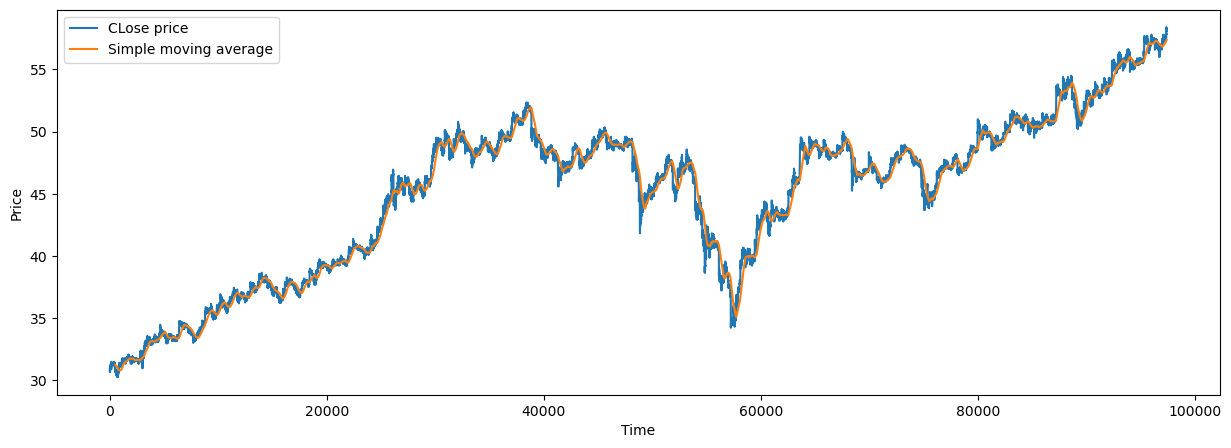

In [3]:
# thêm các cột giá trị giá đóng cửa và khối lượng giao dịch của phiên trước đó
fpt_df['Pre_close'] = fpt_df.loc[:,['Close']].shift(1)
fpt_df['Pre_volume'] = fpt_df.loc[:,['Volume']].shift(1)

# tính trung bình động của giá đóng cửa một số phiên giao dịch
fpt_df['50SMA'] = fpt_df['Pre_close'].rolling(50).mean()
fpt_df['100SMA'] = fpt_df['Pre_close'].rolling(100).mean()
fpt_df['200SMA'] = fpt_df['Pre_close'].rolling(200).mean()
fpt_df['500SMA'] = fpt_df['Pre_close'].rolling(500).mean()
fpt_df['1000SMA'] = fpt_df['Pre_close'].rolling(1000).mean()

# vẽ biểu đồ giá đóng cửa và trung bình động giá đóng cửa trong 500 phiên

plt.figure(figsize=(15,5))
plt.plot(fpt_df['Close'])
plt.plot(fpt_df['500SMA'])
plt.title('')
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend(['CLose price', 'Simple moving average'], loc='upper left')
plt.show()

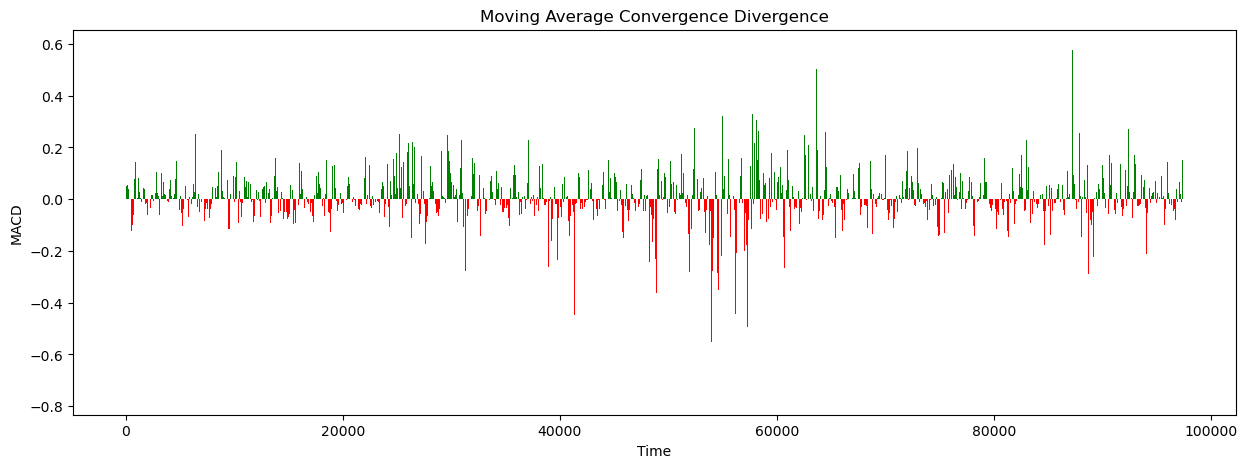

In [4]:
# tính Moving Average Convergence Divergence (MACD)
def macd(data,len1,len2,len3):
  shortEMA = data.ewm(span = len1,adjust = False).mean()
  longEMA = data.ewm(span = len2,adjust = False).mean()
  macd = shortEMA - longEMA
  signal = macd.ewm(len3,adjust = False).mean()
  return macd,signal

macd, signal = macd(fpt_df['Pre_close'],52,100,52)
#macd, signal = macd(fpt_df['Pre_close'],3,8,6)
fpt_df['MACD'] = macd
fpt_df['signal_MACD'] = signal

# plot MACD
plt.figure(figsize = (15,5))
colors = np.array(['green']*len(fpt_df['MACD']))
colors[fpt_df['MACD']<0]='red'
plt.bar(fpt_df.index.values,fpt_df['MACD'],color = colors)
plt.title('')
plt.ylabel('MACD')
plt.xlabel('Time')
plt.title('Moving Average Convergence Divergence')
#plt.plot(fpt_df['signal_MACD'],color = 'blue')
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

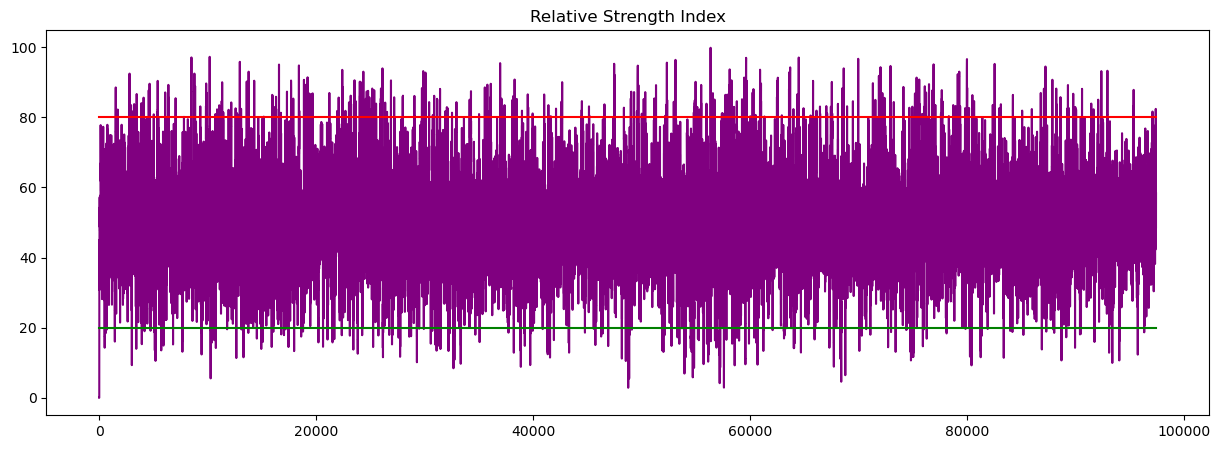

In [5]:
# tính Relative Strength Index (RSI)
def RSI(data,period):
  delta = data.diff()
  up =  delta.clip(lower=0)
  down = -1*delta.clip(upper=0)
  ema_up = up.ewm(com=period, adjust=False).mean()
  ema_down = down.ewm(com=period, adjust=False).mean()
  rs = ema_up/ema_down
  rsi = 100-(100/(1+rs))
  return rsi

fpt_df['RSI'] = RSI(fpt_df['Pre_close'],13)
fpt_df['RSI_volume'] = RSI(fpt_df['Pre_volume'],13)

x = fpt_df.index.values
# plot RSI
plt.figure(figsize=(15,5))
plt.plot(fpt_df['RSI'],color = 'purple')
plt.plot([x[0],x[-1]],[80,80],color='red')
plt.plot([x[0],x[-1]],[20,20],color='green')
plt.title('Relative Strength Index')
plt.show


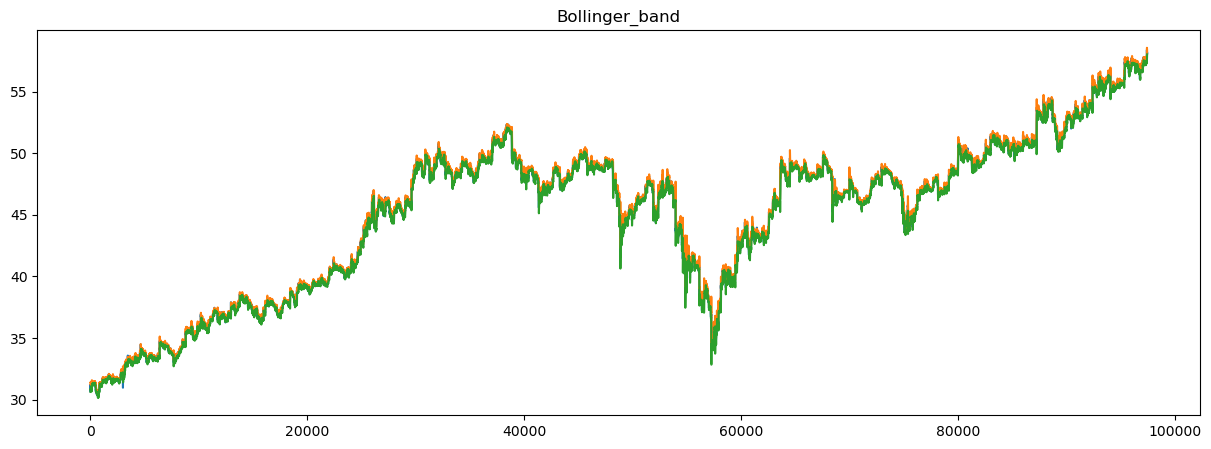

In [6]:
# tính Bollinger_band
def Bollinger_band(data,period):
  mean = data.rolling(period).mean()
  std = data.rolling(period).std()
  upper_band = np.array(mean) + 2*np.array(std)
  lower_band = np.array(mean) - 2*np.array(std)
  return upper_band, lower_band


fpt_df['Upper_band'], fpt_df['Lower_band'] = Bollinger_band(fpt_df['Pre_close'],20)

# plot bollinger_band
plt.figure(figsize=(15,5))
plt.plot(fpt_df['Pre_close'])
plt.plot(fpt_df['Upper_band'])
plt.plot(fpt_df['Lower_band'])
plt.title('Bollinger_band')
plt.show()

In [7]:
fpt_df = fpt_df.replace(np.inf,np.nan).dropna()#loại bỏ các hàng chứa giá trị null
fpt_df['Fluct'] = (fpt_df['Close']-fpt_df['Pre_close'])#tính toán biến động giá cổ phiếu theo từng phiên
fpt_df['Target'] = (fpt_df['Fluct'] > 0).astype(int)
# Cột target này nếu giá cổ phiếu biến động tăng thì sẽ có giá trị là '1' còn không tăng hoặc giảm sẽ là '0'
fpt_df

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest,Pre_close,Pre_volume,...,500SMA,1000SMA,MACD,signal_MACD,RSI,RSI_volume,Upper_band,Lower_band,Fluct,Target
1000,FPT,1/8/2023 10:12,31.22,31.22,31.22,31.22,600,0,31.19,570.0,...,30.79888,31.01582,0.005058,0.039570,47.602836,47.006053,31.263205,31.130795,0.03,1
1001,FPT,1/8/2023 10:13,31.22,31.22,31.22,31.22,500,0,31.22,600.0,...,30.79946,31.01615,0.005270,0.038923,55.365316,47.056642,31.255166,31.149834,0.00,0
1002,FPT,1/8/2023 10:14,31.26,31.26,31.26,31.26,6300,0,31.22,500.0,...,30.80004,31.01656,0.005466,0.038291,55.365316,46.895939,31.238157,31.177843,0.04,1
1003,FPT,1/8/2023 10:15,31.26,31.26,31.26,31.26,30,0,31.26,6300.0,...,30.80078,31.01708,0.006364,0.037689,63.684688,56.232170,31.248364,31.174636,0.00,0
1004,FPT,1/8/2023 10:16,31.30,31.30,31.30,31.30,1730,0,31.26,30.0,...,30.80168,31.01760,0.007207,0.037114,63.684688,46.678231,31.256295,31.173705,0.04,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97401,FPT,12/22/2024 14:24,58.20,58.20,58.20,58.20,27470,0,58.20,30600.0,...,57.37580,57.14400,0.158651,0.068614,58.598755,53.040646,58.424781,57.975219,0.00,0
97402,FPT,12/22/2024 14:25,58.20,58.20,58.20,58.20,14820,0,58.20,27470.0,...,57.37860,57.14500,0.159584,0.070330,58.598755,52.192002,58.394167,57.985833,0.00,0
97403,FPT,12/22/2024 14:26,58.20,58.20,58.20,58.20,500,0,58.20,14820.0,...,57.38140,57.14590,0.160346,0.072029,58.598755,48.794071,58.382617,57.987383,0.00,0
97404,FPT,12/22/2024 14:29,58.10,58.10,58.10,58.10,2500,0,58.20,500.0,...,57.38440,57.14680,0.160944,0.073706,58.598755,45.206131,58.345139,58.004861,-0.10,0


In [8]:
# chia tập dữ liệu thành tâp train và test
y = fpt_df['Close']# đầu ra của mô hình là giá cổ phiếu của phiên sau
X = fpt_df.drop(['Close','Volume','Fluct','Ticker','Date/Time','High','Low','Target'],axis=1).values
# đầu vào là các giá trị đã tính toán với các phiên trước đó
num_test = 10000 # tập dữ liệu gồm 135354 phiên nên sẽ lấy 125354 phiên để train còn lại để test là 10000
X_train = X[:-1*num_test]
y_train = y[:-1*num_test]
X_test = X[-1*num_test:]
y_test = y[-1*num_test:]

# Xây dựng model linear regression và train model
model = LinearRegression() #xây dựng model
model = model.fit(X_train,y_train) #Train model

<function matplotlib.pyplot.show(close=None, block=None)>

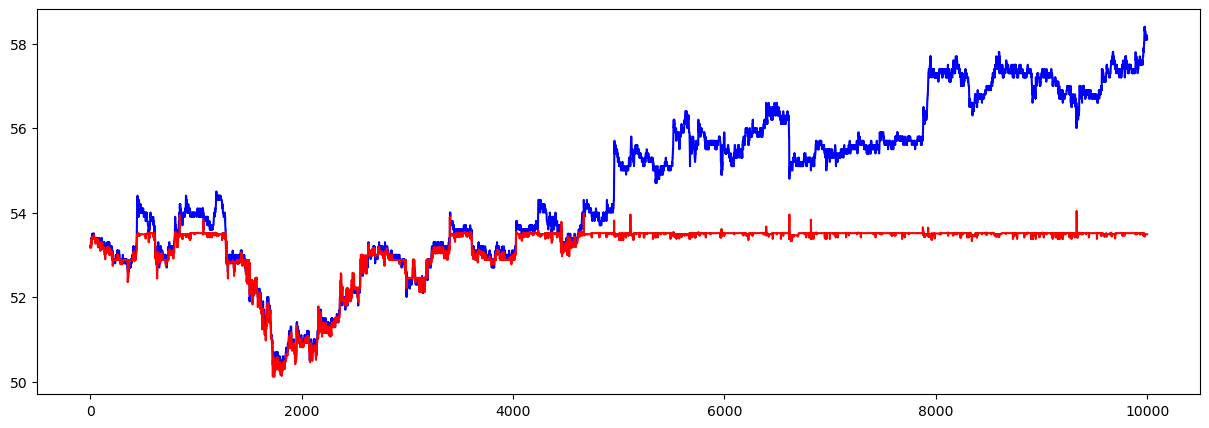

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
model_xgboost = GradientBoostingRegressor(random_state = 42)
model_xgboost.fit(X_train,y_train)
result_predict = model_xgboost.predict(X_test)
plt.figure(figsize=(15,5))
plt.plot(range(len(y_test)),y_test,color='blue')
plt.plot(range(len(result_predict)),result_predict,color='red')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

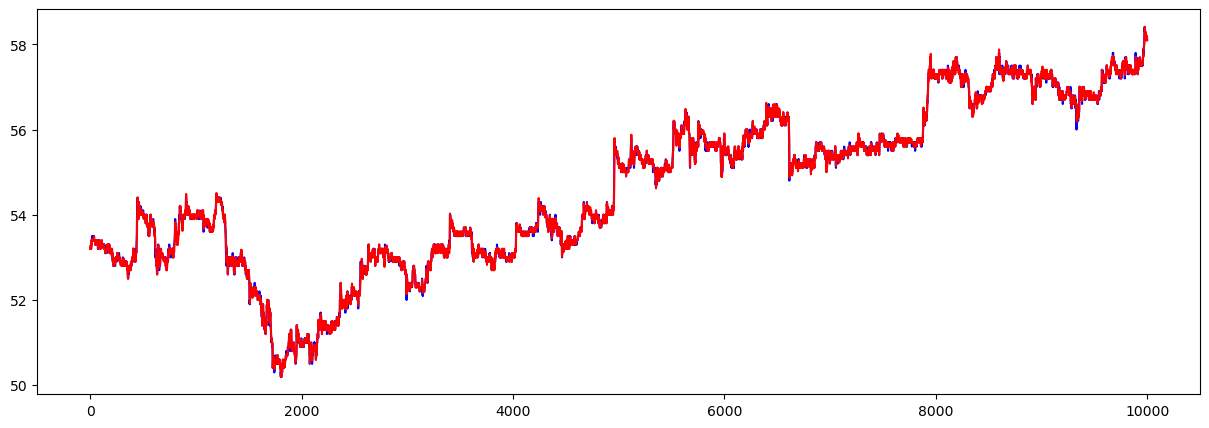

In [10]:
predicts = model.predict(X_test) #sử dụng model dự đoán cho tập test

# vẽ tập dữ liệu test dự đoán và thực tế
plt.figure(figsize=(15,5))
plt.plot(range(len(y_test)),y_test,color='blue')
plt.plot(range(len(predicts)),predicts,color='red')
plt.show

In [11]:
df = pd.DataFrame()
pre = fpt_df['Pre_close']
ref = fpt_df['Fluct']
target = fpt_df['Target']
df['Predict_fluct']=predicts-pre[-10000:]
df['Fluct'] = ref[-10000:]
df['Target'] = target[-10000:]
df['Predict_target'] = (df['Predict_fluct'] > 0).astype(int)
df

,Predict_fluct,Fluct,Target,Predict_target
87406,-0.001960,0.0,0,0
87407,-0.002702,0.0,0,0
87408,0.074762,0.0,0,1
87409,0.074890,0.0,0,1
87410,-0.002798,0.0,0,0
...,...,...,...,...
97401,0.000194,0.0,0,1
97402,0.000069,0.0,0,1
97403,-0.001238,0.0,0,0
97404,-0.080107,-0.1,0,0


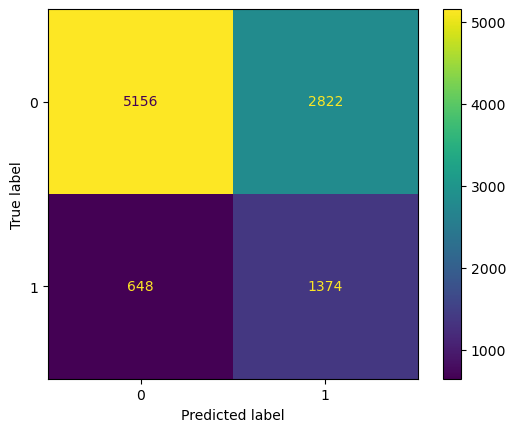

In [12]:
Target = df['Target'].tolist()
Predict_target = df['Predict_target'].tolist()
conf_matrix = confusion_matrix(Target,Predict_target)
disp = ConfusionMatrixDisplay( confusion_matrix=conf_matrix)
disp.plot()
plt.show()

In [13]:
accuracy = accuracy_score(Target, Predict_target)
print('Accuracy: %f' % accuracy)

Accuracy: 0.653000
